Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
%%capture
!pip install --upgrade pandas-profiling plotly
!pip install fiona
!pip install geopy

In [0]:
# Disable warning
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [223]:
import os, sys

# Pull files from Github repo
os.chdir('/content')
!git init .
!git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
!git pull origin master
    
# Change into directory for module
os.chdir('module3')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [225]:
import pandas as pd
import pandas_profiling
from geopy.geocoders import Nominatim

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)
# Create a FULL_ADDRESS field
df['FULL_ADDRESS'] = df['ADDRESS'] + ' NEW YORK, NY'

df['LAND_SQUARE_FEET'].fillna(0)
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].replace(',','', regex=True)
df['LAND_SQUARE_FEET'] = pd.to_numeric(df['LAND_SQUARE_FEET'], errors='coerce')

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,FULL_ADDRESS
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,10733.0,1979.0,2007.0,2,R4,0,01/01/2019,"447 WEST 18TH STREET, PH12A NEW YORK, NY"
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,2962.0,15435.0,1920.0,4,O5,0,01/01/2019,"144 WEST 37TH STREET NEW YORK, NY"
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,2074.0,11332.0,1930.0,4,O5,0,01/01/2019,"40 WEST 38TH STREET NEW YORK, NY"
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0.0,500.0,0.0,2,R4,0,01/01/2019,"1 SHERIDAN SQUARE, 8C NEW YORK, NY"
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0.0,6406.0,0.0,2,R1,0,01/01/2019,"20 EAST 65TH STREET, B NEW YORK, NY"


In [226]:
# Select the subset of data
df = df[(df['SALE_PRICE'] > 100000) & 
        (df['SALE_PRICE'] < 2000000) & 
        (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')]

print(df.shape)
df.head()

(3151, 22)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,FULL_ADDRESS
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,6800.0,1325.0,1930.0,1,A9,550000,01/01/2019,"4832 BAY PARKWAY NEW YORK, NY"
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,4000.0,2001.0,1940.0,1,A1,200000,01/01/2019,"80-23 232ND STREET NEW YORK, NY"
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,3500.0,2043.0,1925.0,1,A1,810000,01/02/2019,"1260 RHINELANDER AVE NEW YORK, NY"
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,4000.0,2680.0,1899.0,1,A1,125000,01/02/2019,"469 E 25TH ST NEW YORK, NY"
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,1710.0,1872.0,1940.0,1,A5,620000,01/02/2019,"5521 WHITTY LANE NEW YORK, NY"


In [227]:
# Convert created feature to datetime
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

# Split off the train data by January through March 2019
mask = (df['SALE_DATE'] > '2018-12-31') & (df['SALE_DATE'] < '2019-04-01')
train = df.loc[mask]

# Split of the test data by April 2019
mask = (df['SALE_DATE'] >= '2019-04-01')
test = df.loc[mask]

print(train.shape)
print(test.shape)

(2507, 22)
(644, 22)


In [228]:
print(df.loc[137, 'ADDRESS'])

85-11 57 ROAD


In [0]:
def lat_long(address):
  geolocator = Nominatim(user_agent='Test')
  location = geolocator.geocode(address, timeout=None)
  if location:
    return location.longitude, location.latitude
  else:
    return 0.0, 0.0

#full_address = df.loc[137, 'ADDRESS'] + ' NEW YORK, NY'
#lat, long = lat_long(full_address)
#print(lat)
#print(long)

#df['LONGITUDE', 'LATITUDE'] = df.apply(lambda x: lat_long(x['FULL_ADDRESS']), axis=1)

In [230]:
# Check non-numeric features
train.describe(exclude='number')

,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE,FULL_ADDRESS
count,2507,2507,2507,2507,2507,1,2507,2507,2507
unique,176,1,2,13,2497,1,11,68,2497
top,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A1,117-45 125TH STREET,RP.,A1,2019-01-31 00:00:00,"22-40 93RD STREET NEW YORK, NY"
freq,77,2507,2476,919,2,1,919,78,2
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00,NaN


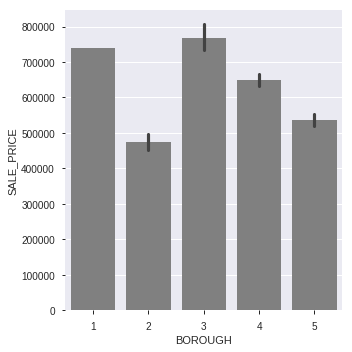

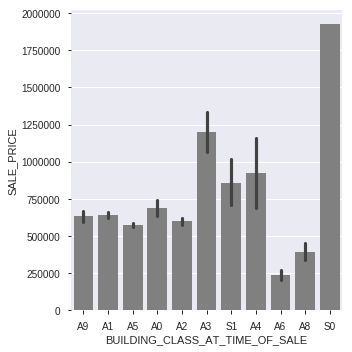

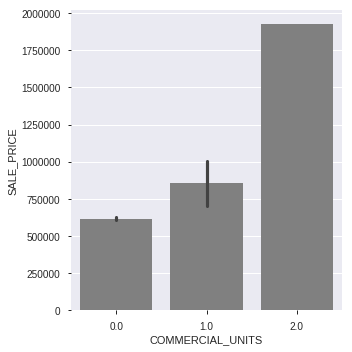

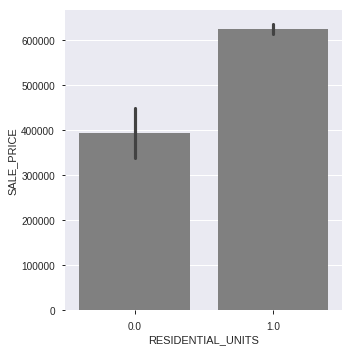

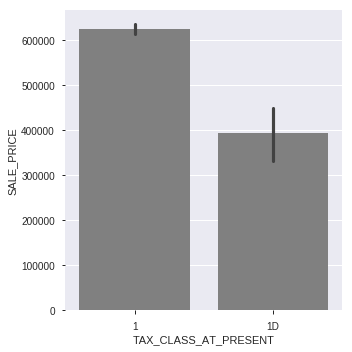

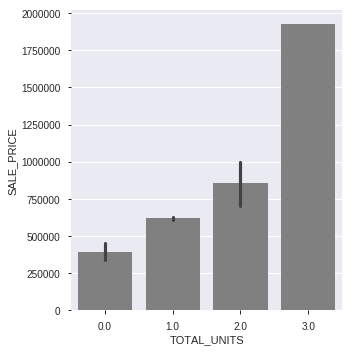

In [231]:
#check numeric features
import matplotlib.pyplot as plt
import seaborn as sns


for col in sorted(train.columns):
    if (train[col].nunique() < 12) & (train[col].nunique() > 1) :
        sns.catplot(x=col, y='SALE_PRICE', data = train, kind = 'bar', color = 'grey')
        plt.show()

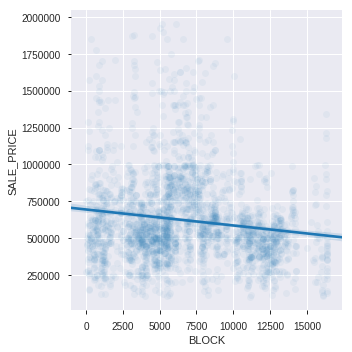

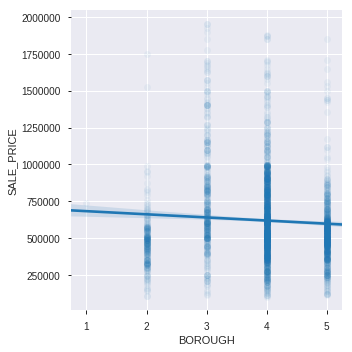

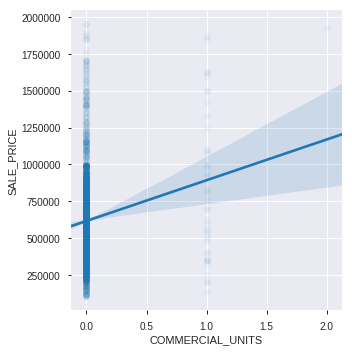

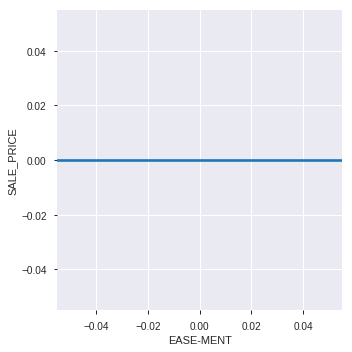

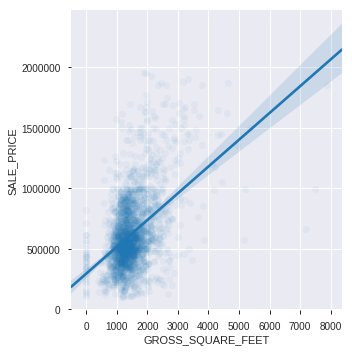

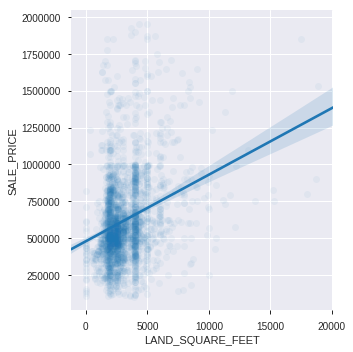

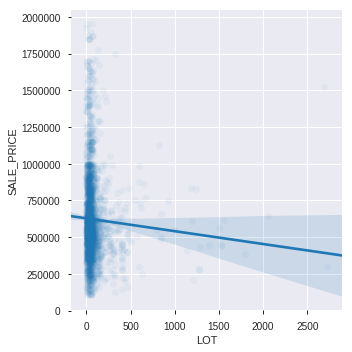

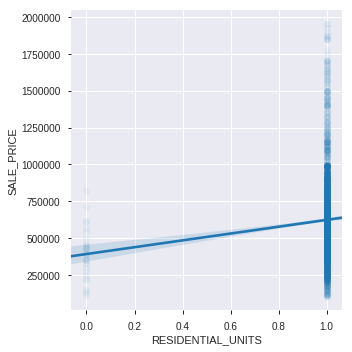

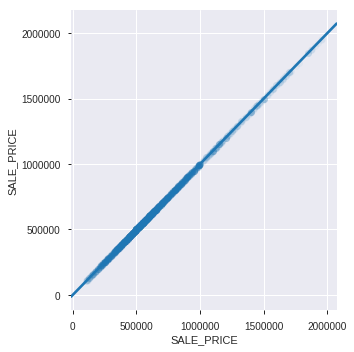

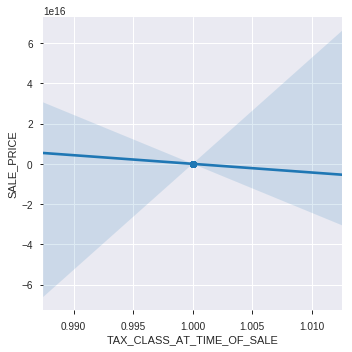

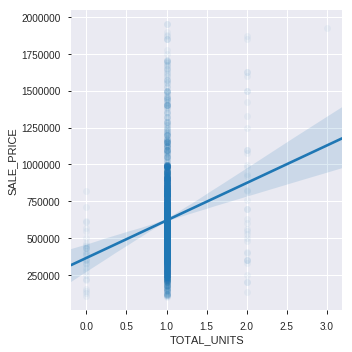

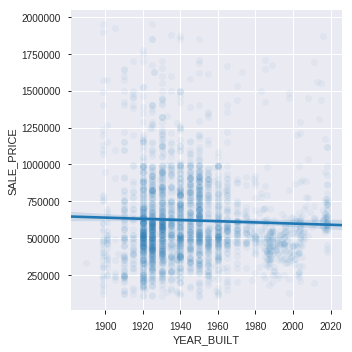

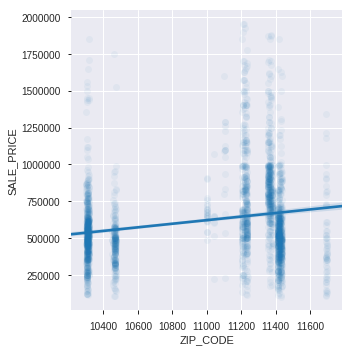

In [232]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y = 'SALE_PRICE', data = train, scatter_kws = dict(alpha=0.05))
    plt.show()

In [233]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'SALE_PRICE'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2507, 11), (2507,), (644, 11), (644,))

In [234]:
#Select the 10 features that best correlate to the target
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k = 10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((2507, 10), (644, 10))

In [235]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

Features selected:
BOROUGH
BLOCK
LOT
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
YEAR_BUILT


In [236]:
# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression
import numpy as np

# 2. Instantiate this class
model = LinearRegression()

# 3. Arrange X features matrix & y target vector
features = ['BOROUGH', 'BLOCK', 'LOT',	'ZIP_CODE',	'RESIDENTIAL_UNITS',	'COMMERCIAL_UNITS',
            'TOTAL_UNITS',	'LAND_SQUARE_FEET',	'GROSS_SQUARE_FEET',	'YEAR_BUILT']
target = 'SALE_PRICE'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

# 4. Fit the model
model.fit(X_train, y_train)

# 5. Apply the model
y_pred = model.predict(X_train)

# Show the coefficient
print('Coefficients', model.coef_, '\n')

# Show the intercept
print('Intercept', model.intercept_, '\n')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Print regression metrics
train_mse = mean_squared_error(y_train, y_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_pred)
train_r2 = r2_score(y_train, y_pred)
print('Train Mean Squared Error:', train_mse)
print('Train Root Mean Squared Error:', train_rmse)
print('Train Mean Absolute Error:', train_mae)
print('Train R^2:', train_r2)
print('\n')

ty_pred = model.predict(X_test)

# Print regression metrics
test_mse = mean_squared_error(y_test, ty_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, ty_pred)
test_r2 = r2_score(y_test, ty_pred)
print('Test Mean Squared Error:', test_mse)
print('Test Root Mean Squared Error:', test_rmse)
print('Test Mean Absolute Error:', test_mae)
print('Test R^2:', test_r2)



Coefficients [-1.82871015e+04 -3.44124408e+01 -1.13677913e+01  3.45609971e+02
 -2.06324845e+05  1.59978774e+05 -4.63460711e+04  3.71099851e+01
  1.69936824e+02  1.17316064e+03] 

Intercept -5273930.397853336 

Train Mean Squared Error: 50168606143.04689
Train Root Mean Squared Error: 223983.49524696433
Train Mean Absolute Error: 159597.46721217915
Train R^2: 0.4097870419480937


Test Mean Squared Error: 55325265499.02819
Test Root Mean Squared Error: 235213.2341069018
Test Mean Absolute Error: 158980.43561658388
Test R^2: 0.3717331725505859
